In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
from scipy import stats

In [3]:
from scipy.ndimage import measurements
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [4]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="64GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.122.89/463326/1' processes=1 threads=256, memory=59.60 GiB>

### Defining functions

In [5]:
def land_sea_mask(dset):
##This function calculate the land_sea mask according to the resolution of the data
###negative values is ocean, positive values is land
    filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
    dsetmask = xr.open_dataset(filemask)
    lsmask01 = dsetmask.landseamask.where(
        dsetmask.landseamask<100).interp(lon=dset.lon.values,lat=dset.lat.values,method='linear') *0 +2
    lsmask01 = lsmask01.where(lsmask01==2,-2)
    return lsmask01

In [6]:
def time_mean_model(file,times,var,lat,lon,environ):
    ##Funtion to calculate the monthly mean of precipitation from the model
    ###the environ option mask the values over land or ocean:
        ## if environ = 'trop' -> no mask is used
        ## if environ = 'ocean' -> return only values over ocean
        ## if environ = 'land' -> return only values over land
    dset = xr.open_mfdataset(file, engine='netcdf4', combine='by_coords',chunks=({'time':20})).sel(
        time=slice(times[0],times[1]))
    if environ is 'trop':
        pr=dset[var].sel(
            time=slice(times[0],times[1])).sel(
            lat=slice(lt[0],lat[1]),lon=slice(lon[0],lon[1])).resample(time='1MS').mean(dim=('time'),skipna=True)
    else:
        lsmask01 = land_sea_mask(dset)
        if environ is 'ocean':
            pr=dset[var].where(lsmask01<0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        elif environ is 'land':
            pr=dset[var].where(lsmask01>0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        else:
            return print('no correct environment')
    jobs = dask.persist(pr)
    varf = dask.compute(pr)[0]
    pr_mon = varf.groupby('time.month').mean()
    return pr_mon*3600*24

In [7]:
def time_mean_imerg_multi(file,lon,lat,environ):
    ##Funtion to calculate the climatology monthly mean of precipitation from IMERG
    ###the environ option mask the values over land or ocean:
        ## if environ = 'trop' -> no mask is used
        ## if environ = 'ocean' -> return only values over ocean
        ## if environ = 'land' -> return only values over land
    data = xr.open_mfdataset(
        file, combine='by_coords',engine='netcdf4',chunks=({'time':20}))['calibrated_precipitation']
    if environ is 'trop':
        pr=data.sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
    else:
        lsmask01 = land_sea_mask(data)
        if environ is 'ocean':
            pr=data.where(lsmask01<0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
        elif environ is 'land':
            pr=data.where(lsmask01>0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
        else:
            return print('Something is wrong')
    
    prmon = pr.resample(time='1MS').mean(dim='time')
    prmon_clim = prmon.groupby('time.month').mean(dim='time')
    
    jobs = dask.persist(prmon_clim)
    progress(jobs, notebook=False)
    precip = dask.compute(prmon_clim)
    
    return precip[0]

**Function to calculate object detection**

In [8]:
def calc_area(data,dx,dy):
    ##Calculate the area of each grid cell in the data
    earthr = 6.371e6
    loncmorph,latcmorph = np.meshgrid(data.lon.values,data.lat.values)
    area = xr.DataArray(data = (dx/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(dy/180*np.pi)*earthr,
                            dims=["lat","lon"],
                            coords=dict(
                            lat=(["lat"],data.lat.values),
                            lon=(["lon"],data.lon.values),))
    return area

In [9]:
def calc_objects(data,threshold,structure):
    ## This function calculates the objects of precipitation according to a threshold and a strcuture
    labels,num = measurements.label(data.where(data>threshold,0),structure=structure)
    ###sorting labels according to index
    labelsu = np.unique(labels);
    labels_n = np.searchsorted(labelsu,labels); 
    indices_n = np.arange(np.max(labels_n)+1);
    return labels_n,indices_n

In [10]:
def cal_statistic(data,area_grid,labels_n,indices_n,threshold):
    ## This function calculates the statistics of the objects as: 
        ##area 
        ##mean precipitation
        ##centroid (longitude and latitude)
    sum_area=ndimage.sum(area_grid,labels_n,indices_n)
    meanp = ndimage.mean((data).where(data>threshold,0),labels_n,indices_n)
    meanp_area = (ndimage.mean(data,labels_n,indices_n)/(ndimage.sum(area_grid,labels_n,indices_n)))
    centr_lat = [data.lat.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][0])] for j in range(
        len(indices_n))]
    centr_lon = [data.lon.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][1])] for j in range(
        len(indices_n))]
    
    stats  = np.zeros((5,len(indices_n)))
    stats[0,:] = sum_area
    stats[1,:] = meanp
    stats[2,:] = meanp_area
    stats[3,:] = centr_lat
    stats[4,:] = centr_lon
    
    return meanp, sum_area, stats

In [11]:
def cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min):
    ##This function caluclates the object with the maximum area 
    sel_ind = indices_n[(meanp>threshold) & (sum_area/1000000>(area_min))]
    nstats = [stats[:,indices_n==sel_ind[i]] for i in range(len(sel_ind))]
    nlabel = [np.where(labels_n==sel_ind[i], data, np.nan) for i in range(len(sel_ind))]
    
    if not sel_ind.any():
        nstats = [np.zeros((5,1))*np.nan]
        return nstats,nlabel
    elif len(sel_ind) == 1:
        return nstats,nlabel
    else:
        area = [nstats[i][0] for i in range(len(sel_ind))]
        max_tuple = max(area, key=lambda x:x[0])
        max_ind = area.index(max_tuple)

        return [nstats[max_ind]], [nlabel[max_ind]]

In [12]:
def object_id(data,dx,dy,structure,threshold,area_min):
    ####create area
    area_grid = calc_area(data,dx,dy) 
    ###calculating objects
    labels_n,indices_n = calc_objects(data,threshold,structure)
    
    ###calculate stats
    meanp, sum_area, stats = cal_statistic(data,area_grid,labels_n,indices_n,threshold)

    ###selecting only the according to the classification 
    return cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min)

*********

**List files of interpolated data ICON-S_WarmEq precipitation**

In [13]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'dpp0052_pr_interpolation'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0052/precip')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0052pp = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**List files of interpolated data ICON-S precipitation**

In [14]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'pr_dpp0066_daily'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0066/precip')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0066pp = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**List files of IMERG**

In [15]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

### Results

**Calculate monthly mean precipitation**

_ICON-S_WarmEq_

In [16]:
times = ['2020-02-01','2020-09-22']
var = 'pr'
pr_ocean = time_mean_model(file_dpp0052pp,times,var,[-30,30],[-180,180],'ocean')

_ICON-S_

In [17]:
pr_ocean66 = time_mean_model(file_dpp0066pp,times,var,[-30,30],[-180,180],'ocean')

_Climatology of IMERG_

In [18]:
imerg_mult_ocean_int= time_mean_imerg_multi(file_imerg,\
                                                                    [-180,180],[-30,30],'ocean')

**Calculate the percentile 80 over the land**

In [19]:
##ICON-S_WarmEq
pr_ocean_q80 = pr_ocean.quantile(0.8,dim=('lon','lat'))

In [20]:
##ICON-S
pr_ocean66_q80 = pr_ocean66.quantile(0.8,dim=('lon','lat'))

In [21]:
##IMERG
pr_imerg_ocean_q80 = imerg_mult_ocean_int.quantile(0.8,dim=('lon','lat'))

**Converting nan values to zero to use in the object detection**

In [22]:
pr2_ocean = pr_ocean.where(pr_ocean>=0,0)

In [23]:
pr2_ocean66 = pr_ocean66.where(pr_ocean66>=0,0)

In [24]:
pr2_imerg_ocean = imerg_mult_ocean_int.where(imerg_mult_ocean_int[0]>=0,0)

**Choose the structure to use in the object detection**\\
see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generate_binary_structure.html

In [25]:
s = ndimage.generate_binary_structure(2,2)

**Atlantic**

_******Identify the biggest object_

In [26]:
##ICON-S_WarmEq
atl_stats =  [object_id(pr2_ocean[i,:,:].sel(lat=slice(-10,20),lon=slice(-60,10)),0.1,0.1,s,\
                                     pr_ocean_q80[i].values,[500*500]) for i in range(pr_ocean_q80.size)]

In [27]:
##ICON-S
atl_stats66 =  [object_id(pr2_ocean66[i,:,:].sel(lat=slice(-10,20),lon=slice(-60,10)),0.1,0.1,s,\
                                     pr_ocean66_q80[i].values,[500*500]) for i in range(pr_ocean66_q80.size)]

In [28]:
##IMERG
atl_imerg_stats =  [object_id(pr2_imerg_ocean[i,:,:].sel(lat=slice(-10,20),lon=slice(-60,10)),0.1,0.1,\
                              s,pr_imerg_ocean_q80[i].values,[500*500]) for i in range(pr_imerg_ocean_q80.size)]

_**Getting the area_

In [29]:
atl_area = [atl_stats[i][0][0][0] for i in range(pr_ocean_q80.size)]

In [30]:
atl_area66 = [atl_stats66[i][0][0][0] for i in range(pr_ocean66_q80.size)]

In [31]:
atl_area_imerg = [atl_imerg_stats[i][0][0][0] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the longitude of the centroid_

In [32]:
atl_loni = [atl_stats[i][0][0][-1] for i in range(pr_ocean_q80.size)]

In [33]:
atl_loni66 = [atl_stats66[i][0][0][-1] for i in range(pr_ocean66_q80.size)]

In [34]:
atl_loni_imerg = [atl_imerg_stats[i][0][0][-1] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the latitude of the centroid_

In [35]:
atl_lati = [atl_stats[i][0][0][-2] for i in range(pr_ocean_q80.size)]

In [36]:
atl_lati66 = [atl_stats66[i][0][0][-2] for i in range(pr_ocean66_q80.size)]

In [37]:
atl_lati_imerg = [atl_imerg_stats[i][0][0][-2] for i in range(pr_imerg_ocean_q80.size)]

**E. Pacific**

_******Identify the biggest object_

In [38]:
epac_stats =  [object_id(pr2_ocean[i,:,:].sel(lat=slice(0,20),lon=slice(-150,-80)),0.1,0.1,s,\
                                     pr_ocean_q80[i].values,[500*500]) for i in range(pr_ocean_q80.size)]

In [39]:
epac66_stats =  [object_id(pr2_ocean66[i,:,:].sel(lat=slice(0,20),lon=slice(-150,-80)),0.1,0.1,s,\
                                     pr_ocean66_q80[i].values,[500*500]) for i in range(pr_ocean66_q80.size)]

In [40]:
epac_imerg_stats =  [object_id(pr2_imerg_ocean[i,:,:].sel(lat=slice(0,20),lon=slice(-150,-80)),0.1,0.1,s,\
                                     pr_imerg_ocean_q80[i].values,[500*500]) for i in range(pr_imerg_ocean_q80.size)]

_**Getting the area_

In [41]:
epac_area = [epac_stats[i][0][0][0] for i in range(pr_ocean_q80.size)]

In [42]:
epac66_area = [epac66_stats[i][0][0][0] for i in range(pr_ocean66_q80.size)]

In [43]:
epac_area_imerg = [epac_imerg_stats[i][0][0][0] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the longitude of the centroid_

In [44]:
epac_loni = [epac_stats[i][0][0][-1] for i in range(pr_ocean_q80.size)]

In [45]:
epac66_loni = [epac66_stats[i][0][0][-1] for i in range(pr_ocean66_q80.size)]

In [46]:
epac_loni_imerg = [epac_imerg_stats[i][0][0][-1] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the latitude of the centroid_

In [47]:
epac_lati = [epac_stats[i][0][0][-2] for i in range(pr_ocean_q80.size)]

In [48]:
epac66_lati = [epac66_stats[i][0][0][-2] for i in range(pr_ocean66_q80.size)]

In [49]:
epac_lati_imerg = [epac_imerg_stats[i][0][0][-2] for i in range(pr_imerg_ocean_q80.size)]

**Indian Ocean**

_******Identify the biggest object_

In [50]:
ind_stats =  [object_id(pr2_ocean[i,:,:].sel(lat=slice(-30,30),lon=slice(50,105)),0.1,0.1,s,\
                                     pr_ocean_q80[i].values,[500*500]) for i in range(pr_ocean_q80.size)]

In [51]:
ind_stats66 =  [object_id(pr2_ocean66[i,:,:].sel(lat=slice(-30,30),lon=slice(50,105)),0.1,0.1,s,\
                                     pr_ocean66_q80[i].values,[500*500]) for i in range(pr_ocean66_q80.size)]

In [52]:
ind_imerg_stats =  [object_id(pr2_imerg_ocean[i,:,:].sel(lat=slice(-30,30),lon=slice(50,105)),0.1,0.1,s,\
                              pr_imerg_ocean_q80[i].values,[500*500]) for i in range(pr_imerg_ocean_q80.size)]

_**Getting the area_

In [53]:
ind_area = [ind_stats[i][0][0][0] for i in range(pr_ocean_q80.size)]

In [54]:
ind_area66 = [ind_stats66[i][0][0][0] for i in range(pr_ocean66_q80.size)]

In [55]:
ind_area_imerg = [ind_imerg_stats[i][0][0][0] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the longitude of the centroid_

In [56]:
ind_loni = [ind_stats[i][0][0][-1] for i in range(pr_ocean_q80.size)]

In [57]:
ind_loni66 = [ind_stats66[i][0][0][-1] for i in range(pr_ocean66_q80.size)]

In [58]:
ind_loni_imerg = [ind_imerg_stats[i][0][0][-1] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the latitude of the centroid_

In [59]:
ind_lati = [ind_stats[i][0][0][-2] for i in range(pr_ocean_q80.size)]

In [60]:
ind_lati66 = [ind_stats66[i][0][0][-2] for i in range(pr_ocean66_q80.size)]

In [61]:
ind_lati_imerg = [ind_imerg_stats[i][0][0][-2] for i in range(pr_imerg_ocean_q80.size)]

**Central western Pacific**

Changing the longitude of the data from -180;180 to 0;360

In [62]:
##ICON-S_WamrEq
pr2_ocean2 = pr2_ocean.assign_coords(lon=("lon",np.where(pr2_ocean.lon.values>0,pr2_ocean.lon.values,\
                                                         pr2_ocean.lon.values+360))).sortby("lon")

##ICON-S
pr2_ocean266 = pr2_ocean66.assign_coords(lon=("lon",np.where(pr2_ocean66.lon.values>0,pr2_ocean66.lon.values,\
                                                         pr2_ocean66.lon.values+360))).sortby("lon")

##IMERG
pr2_imerg_ocean2 = pr2_imerg_ocean.assign_coords(lon=("lon",np.where(pr2_imerg_ocean.lon.values>0,\
                                pr2_imerg_ocean.lon.values,pr2_imerg_ocean.lon.values+360))).sortby("lon")


_******Identify the biggest object_

In [63]:
cpac2_stats =  [object_id(pr2_ocean2[i,:,:].sel(lat=slice(0,20),lon=slice(160,210)),0.1,0.1,s,\
                                     pr_ocean_q80[i].values,[500*500]) for i in range(pr_ocean_q80.size)]

In [64]:
cpac2_stats66 =  [object_id(pr2_ocean266[i,:,:].sel(lat=slice(0,20),lon=slice(160,210)),0.1,0.1,s,\
                                     pr_ocean66_q80[i].values,[500*500]) for i in range(pr_ocean66_q80.size)]

In [65]:
cpac2_imerg_stats =  [object_id(pr2_imerg_ocean2[i,:,:].sel(lat=slice(0,20),lon=slice(160,210)),0.1,0.1,s,\
                                pr_imerg_ocean_q80[i].values,[500*500]) for i in range(pr_imerg_ocean_q80.size)]

_**Getting the area_

In [66]:
cpac_area = [cpac2_stats[i][0][0][0] for i in range(pr_ocean_q80.size)]

In [67]:
cpac_area66 = [cpac2_stats66[i][0][0][0] for i in range(pr_ocean66_q80.size)]

In [68]:
cpac_area_imerg = [cpac2_imerg_stats[i][0][0][0] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the longitude of the centroid_

In [69]:
cpac_loni = [cpac2_stats[i][0][0][-1] for i in range(pr_ocean_q80.size)]

In [70]:
cpac_loni66 = [cpac2_stats66[i][0][0][-1] for i in range(pr_ocean66_q80.size)]

In [71]:
cpac_loni_imerg = [cpac2_imerg_stats[i][0][0][-1] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the latitude of the centroid_

In [72]:
cpac_lati = [cpac2_stats[i][0][0][-2] for i in range(pr_ocean_q80.size)]

In [73]:
cpac_lati66 = [cpac2_stats66[i][0][0][-2] for i in range(pr_ocean66_q80.size)]

In [74]:
cpac_lati_imerg = [cpac2_imerg_stats[i][0][0][-2] for i in range(pr_imerg_ocean_q80.size)]

**Southern Pacific**

_******Identify the biggest object_

In [75]:
spac2_stats =  [object_id(pr2_ocean2[i,:,:].sel(lat=slice(-30,0),lon=slice(160,240)),0.1,0.1,s,\
                                     pr_ocean_q80[i].values,[500*500]) for i in range(pr_ocean_q80.size)]

In [76]:
spac2_stats66 =  [object_id(pr2_ocean266[i,:,:].sel(lat=slice(-30,0),lon=slice(160,240)),0.1,0.1,s,\
                                     pr_ocean66_q80[i].values,[500*500]) for i in range(pr_ocean66_q80.size)]

In [77]:
spac2_imerg_stats =  [object_id(pr2_imerg_ocean2[i,:,:].sel(lat=slice(-30,0),lon=slice(160,240)),0.1,0.1,s,\
                                pr_imerg_ocean_q80[i].values,[500*500]) for i in range(pr_imerg_ocean_q80.size)]

_**Getting the area_

In [78]:
spac_area = [spac2_stats[i][0][0][0] for i in range(pr_ocean_q80.size)]

In [79]:
spac_area66 = [spac2_stats66[i][0][0][0] for i in range(pr_ocean66_q80.size)]

In [80]:
spac_area_imerg = [spac2_imerg_stats[i][0][0][0] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the longitude of the centroid_

In [81]:
spac_loni = [spac2_stats[i][0][0][-1] for i in range(pr_ocean_q80.size)]

In [82]:
spac_loni66 = [spac2_stats66[i][0][0][-1] for i in range(pr_ocean66_q80.size)]

In [83]:
spac_loni_imerg = [spac2_imerg_stats[i][0][0][-1] for i in range(pr_imerg_ocean_q80.size)]

_**Getting the latitude of the centroid_

In [84]:
spac_lati = [spac2_stats[i][0][0][-2] for i in range(pr_ocean_q80.size)]

In [85]:
spac_lati66 = [spac2_stats66[i][0][0][-2] for i in range(pr_ocean66_q80.size)]

In [86]:
spac_lati_imerg = [spac2_imerg_stats[i][0][0][-2] for i in range(pr_imerg_ocean_q80.size)]

**Calculate correlation between ICON-S_Warmeq and IMERG**

_Area_

In [88]:
atl_r = stats.pearsonr(np.concatenate(atl_area),np.concatenate(atl_area_imerg)[1:9])
epac_r = stats.pearsonr(np.concatenate(epac_area),np.concatenate(epac_area_imerg)[1:9])
cpac_r = stats.pearsonr(np.concatenate(cpac_area),np.concatenate(cpac_area_imerg)[1:9])
spac_r = stats.pearsonr(np.concatenate(spac_area)[:-1],np.concatenate(spac_area_imerg)[1:8])
ind_r = stats.pearsonr(np.concatenate(ind_area),np.concatenate(ind_area_imerg)[1:9])

_Latitude_

In [89]:
atl_r_lat = stats.pearsonr(np.concatenate(atl_lati),np.concatenate(atl_lati_imerg)[1:9])
epac_r_lat = stats.pearsonr(np.concatenate(epac_lati),np.concatenate(epac_lati_imerg)[1:9])
cpac_r_lat = stats.pearsonr(np.concatenate(cpac_lati),np.concatenate(cpac_lati_imerg)[1:9])
spac_r_lat = stats.pearsonr(np.concatenate(spac_lati)[:-1],np.concatenate(spac_lati_imerg)[1:8])
ind_r_lat = stats.pearsonr(np.concatenate(ind_lati),np.concatenate(ind_lati_imerg)[1:9])

_Longitude_

In [90]:
atl_r_lon = stats.pearsonr(np.concatenate(atl_loni),np.concatenate(atl_loni_imerg)[1:9])
epac_r_lon = stats.pearsonr(np.concatenate(epac_loni),np.concatenate(epac_loni_imerg)[1:9])
cpac_r_lon = stats.pearsonr(np.concatenate(cpac_loni),np.concatenate(cpac_loni_imerg)[1:9])
spac_r_lon = stats.pearsonr(np.concatenate(spac_loni)[:-1],np.concatenate(spac_loni_imerg)[1:8])
ind_r_lon = stats.pearsonr(np.concatenate(ind_loni),np.concatenate(ind_loni_imerg)[1:9])

**Calculate correlation between ICON-S and ICON-S_WarmEq**

_Area_

In [91]:
atl_r2 = stats.pearsonr(np.concatenate(atl_area66),np.concatenate(atl_area))
epac_r2 = stats.pearsonr(np.concatenate(epac66_area),np.concatenate(epac_area))
cpac_r2 = stats.pearsonr(np.concatenate(cpac_area66),np.concatenate(cpac_area))
spac_r2 = stats.pearsonr(np.concatenate(spac_area66)[:-1],np.concatenate(spac_area)[:-1])
ind_r2 = stats.pearsonr(np.concatenate(ind_area66),np.concatenate(ind_area))

_Latitude_

In [92]:
atl_r_lat2 = stats.pearsonr(np.concatenate(atl_lati66),np.concatenate(atl_lati))
epac_r_lat2 = stats.pearsonr(np.concatenate(epac66_lati),np.concatenate(epac_lati))
cpac_r_lat2 = stats.pearsonr(np.concatenate(cpac_lati66),np.concatenate(cpac_lati))
spac_r_lat2 = stats.pearsonr(np.concatenate(spac_lati66)[:-1],np.concatenate(spac_lati)[:-1])
ind_r_lat2 = stats.pearsonr(np.concatenate(ind_lati66),np.concatenate(ind_lati))

_Longitude_

In [93]:
atl_r_lon2 = stats.pearsonr(np.concatenate(atl_loni66),np.concatenate(atl_loni))
epac_r_lon2 = stats.pearsonr(np.concatenate(epac66_loni),np.concatenate(epac_loni))
cpac_r_lon2 = stats.pearsonr(np.concatenate(cpac_loni66),np.concatenate(cpac_loni))
spac_r_lon2 = stats.pearsonr(np.concatenate(spac_loni66)[:-1],np.concatenate(spac_loni)[:-1])
ind_r_lon2 = stats.pearsonr(np.concatenate(ind_loni66),np.concatenate(ind_loni))

**Transform list to numpy array the area**

In [99]:
##ICON-S_WarmEq
scal_epac = np.concatenate(epac_area)
##ICON-S
scal_epac66 = np.concatenate(epac66_area)
##IMERG
scal_epac_imerg = np.concatenate(epac_area_imerg)[1:9]

In [100]:
scal_cpac = np.concatenate(cpac_area)
scal_cpac66 = np.concatenate(cpac_area66)
scal_cpac_imerg = np.concatenate(cpac_area_imerg)[1:9]

In [101]:
scal_spac = np.concatenate(spac_area)
scal_spac66 = np.concatenate(spac_area66)
scal_spac_imerg = np.concatenate(spac_area_imerg)[1:9]

In [102]:
scal_atl = np.concatenate(atl_area)
scal_atl66 = np.concatenate(atl_area66)
scal_atl_imerg = np.concatenate(atl_area_imerg)[1:9]

In [103]:
scal_ind = np.concatenate(ind_area)
scal_ind66 = np.concatenate(ind_area66)
scal_ind_imerg = np.concatenate(ind_area_imerg)[1:9]

**Call sea surface temperature from simulations**

In [104]:
def time_mean_model(file,times,var,lon,lat,environ):
    if environ is 'trop':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        pr=dset1[var].sel(time=slice(times[0],times[1])).sel(lon=slice(lon[0],lon[1]),lat=slice(lat[0],lat[1])).mean(dim=('time'),skipna=True).compute()
    elif environ is 'ocean':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        lsmask01 = land_sea_mask(dset1)
        pr=dset1[var].where(lsmask01<0).sel(time=slice(times[0],times[1])).sel(lon=slice(lon[0],lon[1]),lat=slice(lat[0],lat[1])).mean(dim=('time'),skipna=True).compute()
    elif environ is 'land':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4', parallel=True)
        ####sea_land_mask
        lsmask01 = land_sea_mask(dset1)
        pr=dset1[var].where(lsmask01>0).sel(time=slice(times[0],times[1])).sel(lon=slice(lon[0],lon[1]),lat=slice(lat[0],lat[1])).mean(dim=('time'),skipna=True).compute()
    return pr

**List files of interpolated data ICON-S_WarmEq precipitation**

In [105]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'dpp0052_ts_interpolation_0.25'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0052/surface_flux')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0052 = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**List files of interpolated data ICON-S precipitation**

In [106]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'dpp0066'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0066/surface_flux')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0066 = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**Calculate monthly mean precipitation**

In [107]:
times52 = ['2020-02-01','2020-09-22']
times66 = ['2020-02-01','2020-09-22']
var = 'ts'

_ICON-S_WarmEq_

In [108]:
ts_52 = time_mean_model(file_dpp0052,times52,var,[-180,180],[-30,30],'trop')

_ICON-S_

In [109]:
ts_66 = time_mean_model(file_dpp0066,times66,var,[-180,180],[-30,30],'trop')

In [110]:
diff_ts = ts_52-ts_66

#### smoothing temperature data 

In [111]:
from scipy.ndimage.filters import gaussian_filter

In [112]:
raw_data = diff_ts

In [113]:
diff_ts_filter = gaussian_filter(raw_data, 2,mode='nearest')

**converting smoothed temperature nump array to dset xarray**

In [114]:
ts = xr.Dataset(
    data_vars=dict(
            ts=(['lat','lon'],diff_ts_filter)
    ),
    coords = dict(
        lon=(['lon'],ts_66.lon.values),
        lat = (['lat'], ts_66.lat.values),
    ),
    attrs = dict(description='Ts difference between dpp0052 and dpp0066'),
)


**masking out land grid cells**

In [115]:
lsmask = land_sea_mask(ts)

In [116]:
ts_sea = ts.ts.where(lsmask<0) 

### Figure 4

In [117]:
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [118]:
colors = ['darkblue','darkcyan','darkcyan','green','green','orange','orange','red']

In [119]:
colors_name = ['darkblue','darkcyan','green','orange','red','brown']

In [120]:
import matplotlib as mpl

In [121]:
cmaps = (mpl.colors.ListedColormap(colors_name))

bounds = [1, 2, 3, 4, 5, 6, 7]
norms = mpl.colors.BoundaryNorm(bounds, cmaps.N)

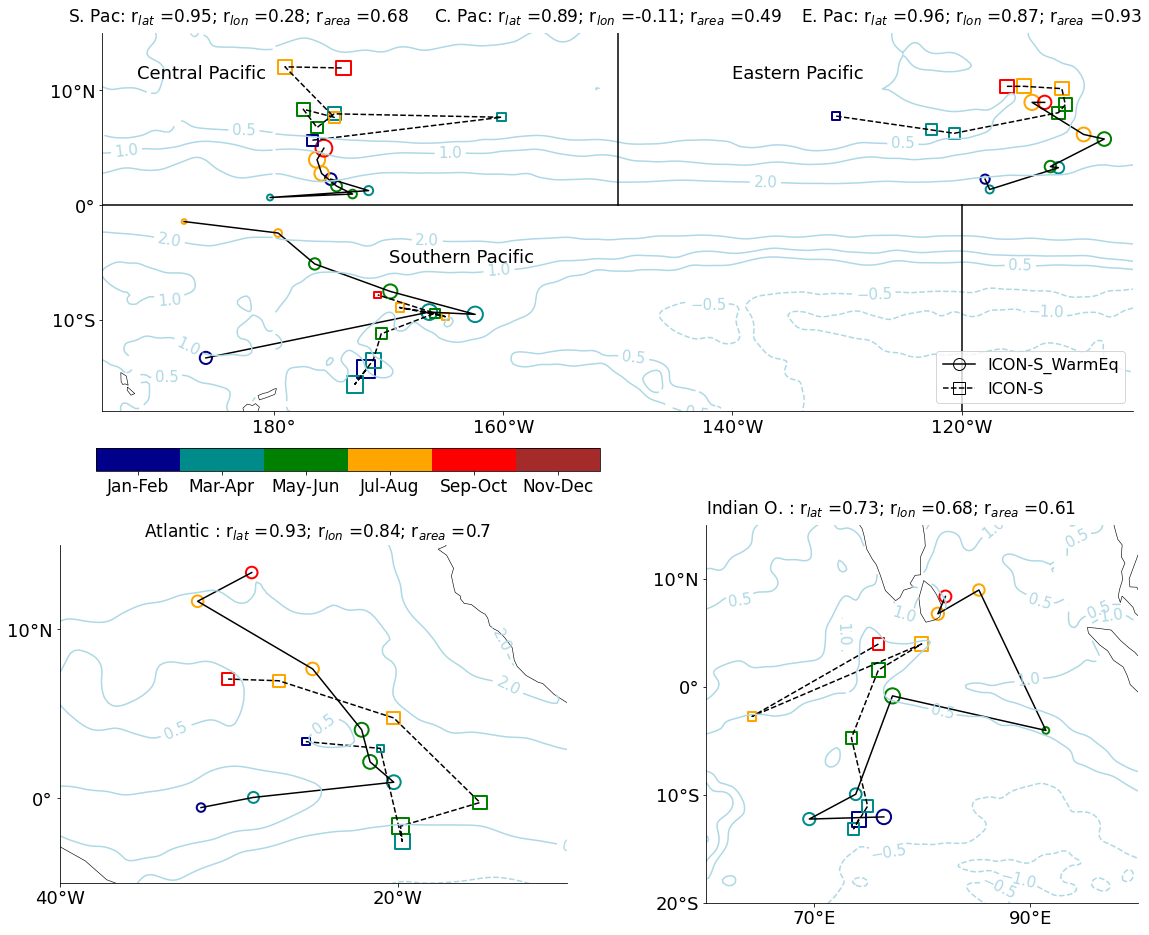

In [122]:
fig = plt.figure(figsize=(20, 16))
ax1=fig.add_axes([0.15,0.5,0.35,0.02])
ax0 = fig.add_subplot(211,projection=ccrs.PlateCarree(central_longitude=180))

###E.Pacific
cs0 = ax0.scatter(epac_loni,epac_lati,s=scal_epac/scal_epac.mean()*150,facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax0.plot(epac_loni,epac_lati,'-k',transform=ccrs.PlateCarree())
cs0_1 = ax0.scatter(epac66_loni,epac66_lati,s=scal_epac66/scal_epac66.mean()*150,marker='s',facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax0.plot(epac66_loni,epac66_lati,'-k',linestyle='--',transform=ccrs.PlateCarree())

ax0.scatter(cpac_loni,cpac_lati,s=scal_cpac/scal_cpac.mean()*150,facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax0.plot(cpac_loni,cpac_lati,'-k',transform=ccrs.PlateCarree())
ax0.scatter(cpac_loni66,cpac_lati66,s=scal_cpac66/scal_cpac66.mean()*150,marker='s',facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax0.plot(cpac_loni66,cpac_lati66,'-k',linestyle='--',transform=ccrs.PlateCarree())

cs1 = ax0.scatter(spac_loni,spac_lati,s=scal_spac/np.nanmean(scal_spac)*150,facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax0.plot(spac_loni,spac_lati,'-k',transform=ccrs.PlateCarree())
cs1_1 = ax0.scatter(spac_loni66,spac_lati66,s=scal_spac_imerg/scal_spac_imerg.mean()*150,marker='s',facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax0.plot(spac_loni66,spac_lati66,'-k',linestyle='--', transform=ccrs.PlateCarree())
ax0.set_extent([165,255, -18, 15], crs=ccrs.PlateCarree())
ax0.coastlines(resolution='110m',linewidth=0.6)
ax0.set_yticks(np.arange(-10,11,10),crs=ccrs.PlateCarree());lat_formatter = LatitudeFormatter();ax0.yaxis.set_major_formatter(lat_formatter)
ax0.set_xticks(np.arange(180,256,20),crs=ccrs.PlateCarree());lon_formatter = LongitudeFormatter();ax0.xaxis.set_major_formatter(lon_formatter)
ax0.tick_params(labelsize=18)
ax0.outline_patch.set_visible(False)
ax0.spines.left.set_visible(True)
ax0.spines.bottom.set_visible(True)

cont1 = ax0.contour(ts_sea.lon,ts_sea.lat,ts_sea,colors='lightblue',levels=[-2,-1,-0.5,0.5,1,2],transform=ccrs.PlateCarree())
plt.clabel(cont1,levels=[-2,-1,-0.5,0.5,1,2],fontsize=15)
###only for legend
ax0.plot(epac_loni,epac_lati,'-ok',markerfacecolor='none',markersize=12,label='ICON-S_WarmEq')
ax0.plot(epac_loni_imerg,epac_lati_imerg,'-sk',markerfacecolor='none',linestyle='--',markersize=12,label='ICON-S')
leg0 = plt.legend(fontsize=16,loc=4)

ax0.plot([165, 255],[0, 0],'-k',transform=ccrs.PlateCarree())
ax0.plot([210, 210],[0, 20],'-k',transform=ccrs.PlateCarree())
ax0.plot([240, 240],[-20, 0],'-k',transform=ccrs.PlateCarree())

plt.text(46,16,'E. Pac: r$_{lat}$ ='+ str(epac_r_lat[0].round(2))+\
             '; r$_{lon}$ ='+ str(epac_r_lon[0].round(2))+'; r$_{area}$ ='+ str(epac_r[0].round(2)),fontsize=17)
plt.text(14,16,'C. Pac: r$_{lat}$ ='+ str(cpac_r_lat[0].round(2))+\
             '; r$_{lon}$ ='+ str(cpac_r_lon[0].round(2))+'; r$_{area}$ ='+ str(cpac_r[0].round(2)),fontsize=17)
plt.text(-18,16,'S. Pac: r$_{lat}$ ='+ str(spac_r_lat[0].round(2))+\
             '; r$_{lon}$ ='+ str(spac_r_lon[0].round(2))+'; r$_{area}$ ='+ str(spac_r[0].round(2)),fontsize=17)

plt.text(40,11,'Eastern Pacific',fontsize=18)
plt.text(-12,11,'Central Pacific',fontsize=18)
plt.text(10,-5,'Southern Pacific',fontsize=18)

ax = fig.add_subplot(223,projection=ccrs.PlateCarree(central_longitude=0))
cs2 = ax.scatter(atl_loni,atl_lati,s=scal_atl/scal_atl.mean()*150,facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(atl_loni,atl_lati,'-k',transform=ccrs.PlateCarree())
cs2_1 = ax.scatter(atl_loni66,atl_lati66,s=scal_atl66/scal_atl66.mean()*150,marker='s',facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(atl_loni66,atl_lati66,'-k',linestyle='--',transform=ccrs.PlateCarree()) 
ax.coastlines(resolution='110m',linewidth=0.6)

ax.set_extent([-40,-10, -5, 15], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(0,11,10),crs=ccrs.PlateCarree());lat_formatter = LatitudeFormatter();ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-40,-9,20),crs=ccrs.PlateCarree());lon_formatter = LongitudeFormatter();ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=18)

plt.text(-35,15.5,'Atlantic : r$_{lat}$ ='+ str(atl_r_lat[0].round(2))+\
             '; r$_{lon}$ ='+ str(atl_r_lon[0].round(2))+'; r$_{area}$ ='+ str(atl_r[0].round(2)),fontsize=17)

ax.outline_patch.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)
cont1 = ax.contour(ts_sea.lon,ts_sea.lat,ts_sea,colors='lightblue',levels=[-2,-1,-0.5,0.5,1,2],transform=ccrs.PlateCarree())
plt.clabel(cont1,levels=[-2,-1,-0.5,0.5,1,2],fontsize=15)

ax = fig.add_subplot(224,projection=ccrs.PlateCarree(central_longitude=0))
ax.scatter(ind_loni,ind_lati,s=scal_ind/scal_ind.mean()*150,facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(ind_loni,ind_lati,'-k',transform=ccrs.PlateCarree())
ax.scatter(ind_loni66,ind_lati66,s=scal_ind66/scal_ind66.mean()*150,marker='s',facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(ind_loni66,ind_lati66,'-k',linestyle='--',transform=ccrs.PlateCarree()) 
ax.coastlines(resolution='110m',linewidth=0.6)
ax.set_extent([60,100, -20, 15], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,16,10),crs=ccrs.PlateCarree());lat_formatter = LatitudeFormatter();ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(70,101,20),crs=ccrs.PlateCarree());lon_formatter = LongitudeFormatter();ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=18)

plt.text(60,16,'Indian O. : r$_{lat}$ ='+ str(ind_r_lat[0].round(2))+\
             '; r$_{lon}$ ='+ str(ind_r_lon[0].round(2))+'; r$_{area}$ ='+ str(ind_r[0].round(2)),fontsize=17)
ax.outline_patch.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)
cont1 = ax.contour(ts_sea.lon,ts_sea.lat,ts_sea,colors='lightblue',levels=[-2,-1,-0.5,0.5,1,2],transform=ccrs.PlateCarree())
plt.clabel(cont1,levels=[-2,-1,-0.5,0.5,1,2],fontsize=15)

cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmaps, norm=norms),
    cax=ax1,
    boundaries= bounds,  # Adding values for extensions.
    extend='neither',
    ticks=[1.5, 2.5, 3.5, 4.5, 5.5 , 6.5],
    spacing='proportional',
    orientation='horizontal',
)

cb1.ax.set_xticklabels(['Jan-Feb','Mar-Apr','May-Jun','Jul-Aug','Sep-Oct','Nov-Dec'],fontsize=17)


plt.subplots_adjust(hspace=0.3)
#plt.savefig('/scratch/m/m300876/results/precip_paper/position_precipitation_srm_icon52_icon66_seasonal_cycle_sal_method_ratio_area_new_no_fill_sst_diff_52_66.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})
